In [10]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
# Import Dataloader
from torch.utils.data import DataLoader, Dataset
# Import ImageFolder
from torchvision import transforms
import torchvision
from torchinfo import summary

### Generating Image Data from Videos

In [11]:
path = 'data/'
datapath = 'image_'+path

# Check if datapath exists
if not os.path.exists(datapath):
    os.makedirs(datapath)

# read video into frames
for category in os.listdir(path):
    categorypath = os.path.join(path, category)
    imagecategorypath = os.path.join(datapath, category)
    for video in os.listdir(categorypath):
        # create folder for each video
        if not os.path.exists(imagecategorypath):
            os.makedirs(imagecategorypath)
        videopath = os.path.join(categorypath, video)
        vidcap = cv2.VideoCapture(videopath)
        success,image = vidcap.read()
        image_list = []
        count = 0
        while success:
            image_list.append(image)
            success,image = vidcap.read()
            count += 1
        # choose 16 equidistant frames
        image_list = np.array(image_list)
        image_list = image_list[np.linspace(0, count-1, 16, dtype=int)]
        # save frames as images in folder
        if not os.path.exists(imagecategorypath+'/'+ video[:-4]+'/'):
            os.makedirs(imagecategorypath+'/'+ video[:-4]+'/')
        for i in range(16):
            imagepath = os.path.join(imagecategorypath+'/', video[:-4]+'/'+str(i)+'.jpg')
            print(imagepath)
            cv2.imwrite(imagepath, image_list[i])

## Creating Dataset

In [12]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        for category in os.listdir(root_dir):
            categorypath = os.path.join(root_dir, category)
            for video in os.listdir(categorypath):
                videopath = os.path.join(categorypath, video)
                self.data.append((videopath, category))
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}
        self.idx_to_class = {i: self.classes[i] for i in range(len(self.classes))}
        self.num_samples = len(self.data)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        videopath, label = self.data[idx]
        images = []
        for item in os.listdir(videopath):
            imagepath = os.path.join(videopath, item)
            image = np.array(Image.open(imagepath))
            if self.transform:
                image = self.transform(image)
            images.append(image)
        images = np.array(images)
        return images, self.class_to_idx[label]
    
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
dataset = VideoDataset(root_dir='image_data/', transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=4)

In [13]:
count_dict = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0
}
for images, label in test_dataset:
    count_dict[label] += 1

In [14]:
count_dict

{0: 13, 1: 17, 2: 17, 3: 18, 4: 15}

In [15]:
            # label to text
dataset.idx_to_class



{0: 'laugh', 1: 'pullup', 2: 'punch', 3: 'pick', 4: 'pour'}

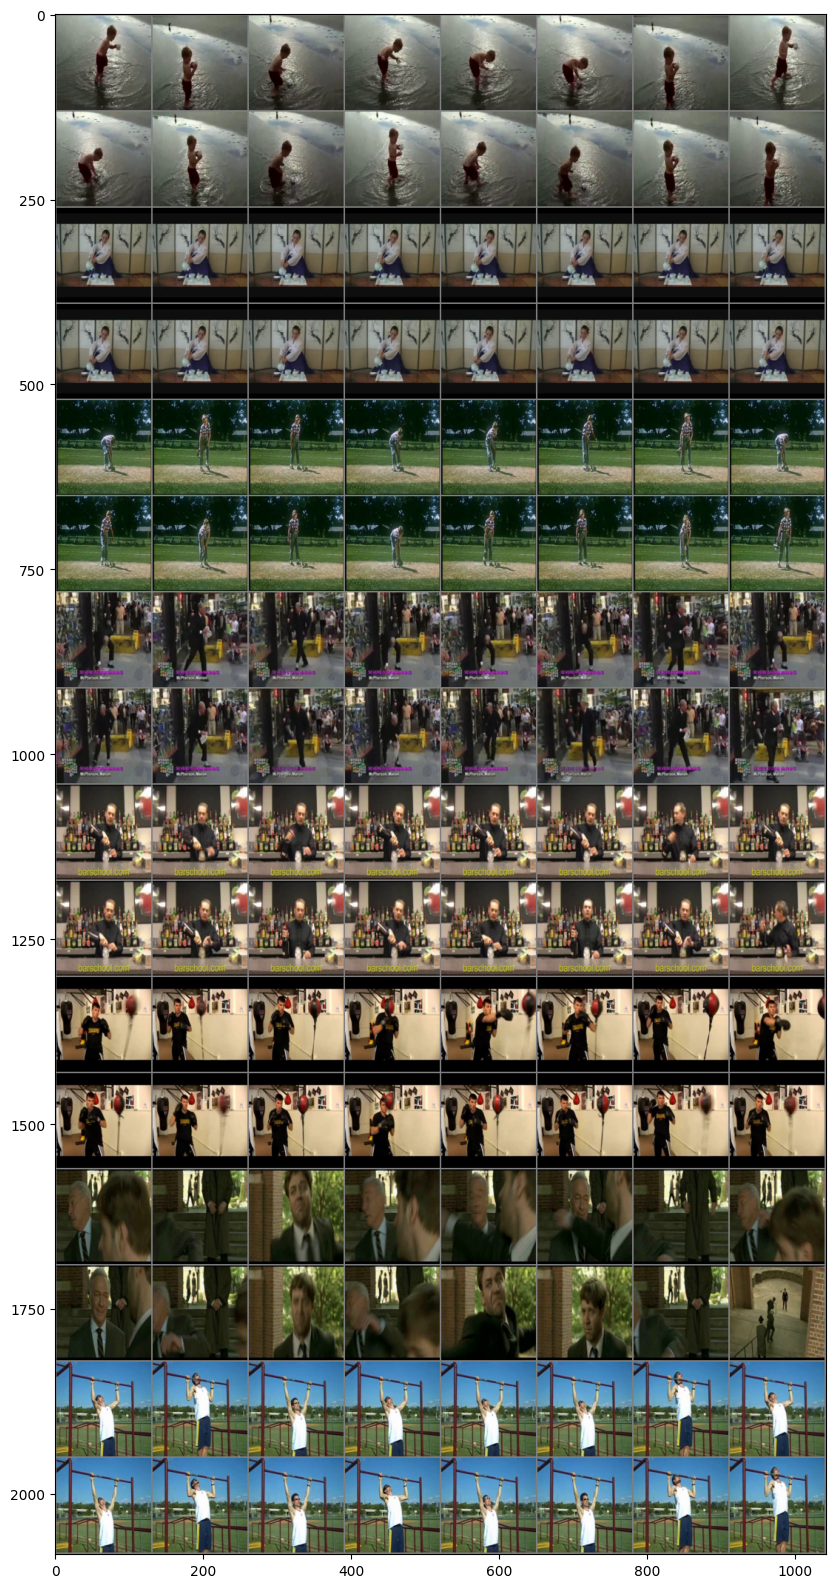

 pick  pour  pick  pick  pour punch punch pullup


In [16]:
# Display training images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
for images, labels in train_loader:
    # resize images
    images = images.reshape(-1, 3, 128, 128)
    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % dataset.idx_to_class[labels[j].item()] for j in range(8)))
    break


#### Sanity Check

In [17]:
for images, label in train_loader:
    print(images.shape)
    print(label.shape)
    break

torch.Size([8, 16, 3, 128, 128])
torch.Size([8])


## Defining RNN Model

In [18]:
class NetRnn(nn.Module):

    def __init__(self):
        super(NetRnn, self).__init__()

        conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 2)
        pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2)
        pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.bn = nn.BatchNorm2d(64)
        self.feat_extractor=nn.Sequential(conv1,nn.ReLU(),pool1,conv2,nn.ReLU(),pool2)
        self.rnn = nn.LSTM(input_size=64*7*7, hidden_size=128, num_layers=2,batch_first=True)
        self.fc1 = nn.Linear(128, 5)

    def forward(self, x):
        batch_size, frames, channels, h, w = x.shape
        x = x.view(batch_size*frames,channels,h,w)
        y = self.feat_extractor(x)
        y = self.bn(y)
        y = y.view(batch_size,frames,-1)
        emb, (hn, cn) = self.rnn(y)
        out = self.fc1(emb[:,-1,:])
        return out


fixed_model_rnn = NetRnn().cuda()
summary(fixed_model_rnn, input_size=(8, 16, 3, 128, 128), device='cuda')


Layer (type:depth-idx)                   Output Shape              Param #
NetRnn                                   [8, 5]                    --
├─Sequential: 1-1                        [128, 64, 7, 7]           --
│    └─Conv2d: 2-1                       [128, 32, 63, 63]         896
│    └─ReLU: 2-2                         [128, 32, 63, 63]         --
│    └─MaxPool2d: 2-3                    [128, 32, 31, 31]         --
│    └─Conv2d: 2-4                       [128, 64, 15, 15]         18,496
│    └─ReLU: 2-5                         [128, 64, 15, 15]         --
│    └─MaxPool2d: 2-6                    [128, 64, 7, 7]           --
├─BatchNorm2d: 1-2                       [128, 64, 7, 7]           128
├─LSTM: 1-3                              [8, 16, 128]              1,804,288
├─Linear: 1-4                            [8, 5]                    645
Total params: 1,824,453
Trainable params: 1,824,453
Non-trainable params: 0
Total mult-adds (G): 1.22
Input size (MB): 25.17
Forward/backward

## Training Model with Validation

Epoch: 1, Loss: 4.32155
Accuracy: 63.75%
Epoch: 2, Loss: 3.61108
Accuracy: 78.75%
Epoch: 3, Loss: 3.21699
Accuracy: 81.25%
Epoch: 4, Loss: 2.91102
Accuracy: 77.50%
Epoch: 5, Loss: 3.51975
Accuracy: 80.00%
Epoch: 6, Loss: 2.86077
Accuracy: 77.50%
Epoch: 7, Loss: 2.68617
Accuracy: 81.25%
Epoch: 8, Loss: 3.07223
Accuracy: 83.75%
Epoch: 9, Loss: 2.67354
Accuracy: 75.00%
Epoch: 10, Loss: 2.38772
Accuracy: 76.25%
Epoch: 11, Loss: 2.40584
Accuracy: 78.75%
Epoch: 12, Loss: 2.50901
Accuracy: 80.00%
Epoch: 13, Loss: 2.62269
Accuracy: 68.75%
Epoch: 14, Loss: 2.20388
Accuracy: 77.50%
Epoch: 15, Loss: 2.30268
Accuracy: 76.25%
Epoch: 16, Loss: 2.76537
Accuracy: 80.00%
Epoch: 17, Loss: 2.09620
Accuracy: 81.25%
Epoch: 18, Loss: 2.71456
Accuracy: 80.00%
Epoch: 19, Loss: 2.08197
Accuracy: 81.25%
Epoch: 20, Loss: 2.12183
Accuracy: 83.75%
Epoch: 21, Loss: 2.23180
Accuracy: 81.25%
Epoch: 22, Loss: 2.01398
Accuracy: 88.75%
Epoch: 23, Loss: 2.31550
Accuracy: 86.25%
Epoch: 24, Loss: 1.82478
Accuracy: 86.25%
E

/tmp/ipykernel_148784/3571773357.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


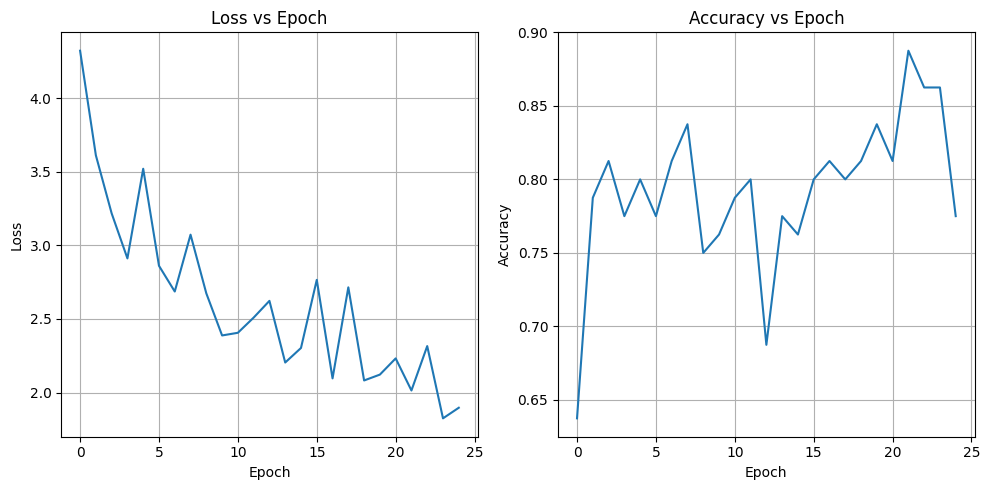

In [19]:
fixed_model_rnn = NetRnn().cuda()

def train_loop(model, eval_func):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    acc = []
    l_list = []
    for epoch in range(25):
        for images, labels in train_loader:
            images = images.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels) + 5e-5 * torch.norm(torch.cat([x.view(-1) for x in model.parameters()]), 1)
            loss.backward()
            optimizer.step()
        print('Epoch: {}, Loss: {:.5f}'.format(epoch+1, loss.item()))
        l_list.append(loss.item())
        acc.append(eval_func(model))
        model.train()
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(l_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.tight_layout()
    plt.grid()
    plt.subplot(1,2,2)
    plt.plot(acc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.tight_layout()
    plt.grid()
    plt.show()

    # Save model
    torch.save(model.state_dict(), 'rnn_model.pt')


def test_loop(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda()
            labels = labels.cuda()
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy: {:.2f}%'.format(100 * correct / total))
    return correct / total

train_loop(fixed_model_rnn, test_loop)

## Training Model with Limited Frame Validation

Epoch: 1, Loss: 4.37179
Accuracy: 57.50%
Epoch: 2, Loss: 3.60434
Accuracy: 77.50%
Epoch: 3, Loss: 3.56195
Accuracy: 80.00%
Epoch: 4, Loss: 3.26765
Accuracy: 80.00%
Epoch: 5, Loss: 3.71177
Accuracy: 73.75%
Epoch: 6, Loss: 2.98222
Accuracy: 78.75%
Epoch: 7, Loss: 2.70366
Accuracy: 83.75%
Epoch: 8, Loss: 2.64148
Accuracy: 81.25%
Epoch: 9, Loss: 2.56372
Accuracy: 87.50%
Epoch: 10, Loss: 2.71558
Accuracy: 71.25%
Epoch: 11, Loss: 2.54630
Accuracy: 72.50%
Epoch: 12, Loss: 2.42853
Accuracy: 76.25%
Epoch: 13, Loss: 2.73168
Accuracy: 71.25%
Epoch: 14, Loss: 2.36573
Accuracy: 80.00%
Epoch: 15, Loss: 2.26165
Accuracy: 83.75%
Epoch: 16, Loss: 2.17500
Accuracy: 81.25%
Epoch: 17, Loss: 2.15622
Accuracy: 80.00%
Epoch: 18, Loss: 2.28332
Accuracy: 73.75%
Epoch: 19, Loss: 2.29201
Accuracy: 73.75%
Epoch: 20, Loss: 2.10058
Accuracy: 68.75%
Epoch: 21, Loss: 2.40668
Accuracy: 76.25%
Epoch: 22, Loss: 2.07593
Accuracy: 77.50%
Epoch: 23, Loss: 2.04718
Accuracy: 77.50%
Epoch: 24, Loss: 1.96618
Accuracy: 82.50%
E

/tmp/ipykernel_148784/3571773357.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


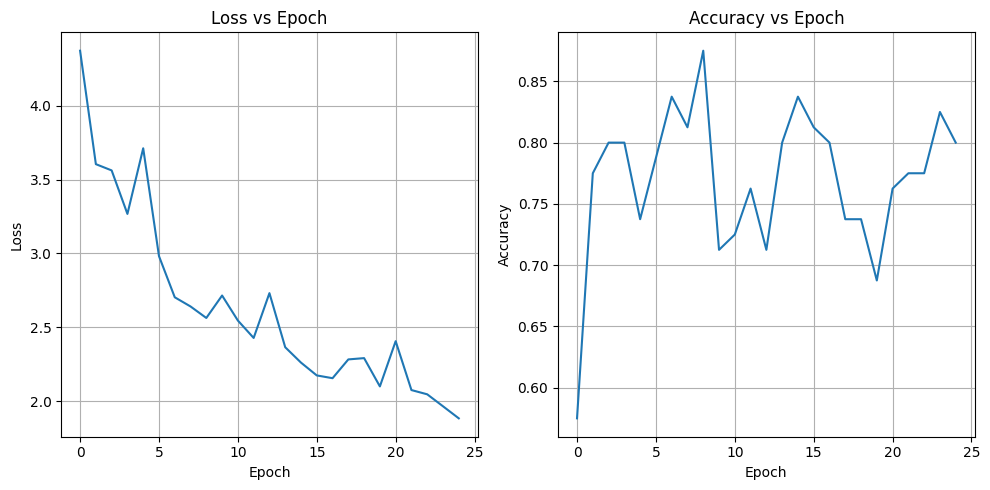

In [20]:
fixed_model_rnn = NetRnn().cuda()

def eval_2_8(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            n_frames = np.random.randint(2, 8)
            images = images[:,torch.linspace(0, 15, n_frames, dtype=int)]
            images = torch.repeat_interleave(images, 16//n_frames, axis=1)
            images = images.cuda()
            labels = labels.cuda()
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy: {:.2f}%'.format(100 * correct / total))
    return correct / total

train_loop(fixed_model_rnn, eval_2_8)